<a href="https://colab.research.google.com/github/yashyenugu/ML-assignment/blob/development/Assignment-2/Logistic-Regression/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression

## Imports

In [20]:
import numpy as np
import pandas as pd
from tqdm import notebook
import matplotlib.pyplot as plt
import pickle
import os
import tqdm

## Data Preprocessing

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
PARENT = '/gdrive/MyDrive/Projects/ML_Models/'

### Loading Data

In [6]:
%cd /gdrive/MyDrive/Projects/ML_Models/

/gdrive/MyDrive/Projects/ML_Models


In [7]:
df =  pd.read_csv('dataset_LR.csv')

### Data Analysis

In [ ]:
df.head()

,attr1,attr2,attr3,attr4,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [ ]:
df.describe()

,attr1,attr2,attr3,attr4,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


### Data Preprocessing

#### Trial

In [ ]:
l = np.zeros((2, 137, 4))
l[0] = X[:137]
l[1] = X[137:274]

In [ ]:
l[1].shape

(137, 4)

In [ ]:
np.random.shuffle(X, seed)

In [ ]:
X

array([[-0.62043 ,  0.5587  , -0.38587 , -0.66423 ],
       [ 4.7965  ,  6.9859  , -1.9967  , -0.35001 ],
       [-1.7344  ,  2.0175  ,  7.7618  ,  0.93532 ],
       ...,
       [ 3.9719  ,  1.0367  ,  0.75973 ,  1.0013  ],
       [ 4.1425  , -3.6792  ,  3.8281  ,  1.6297  ],
       [-1.005   ,  0.084831, -0.2462  ,  0.45688 ]])

In [ ]:
def to_numpy_array(df):
    '''
    Splits the dataset into attributes/features and converts them to numpy arrays

    df = Dataset (pandas Dataframe)
    '''
    return np.array(df.iloc[:,:-1]), np.array(df.iloc[:,-1])

def divide(X, y, n=10):
    '''
    Divides the X and y data into 'n' parts
    
    X = Attribute values (Numpy Array)
    y = Labels (Numpy Array)
    n = No. of divides
    '''
    k = int(X.shape[0]/n)
    X_t = np.zeros((n, k, X.shape[1]))
    y_t = np.zeros((n, k))
    for i in range(0, n):
        X_t[i] = X[(i*k):((i+1)*k)]
        y_t[i] = y[(i*k):((i+1)*k)]
    
    return X_t, y_t

def split(X, y, train_size=0.7):
    '''
    Splits each of the 'n' parts into train and test data
    Returns X_train, y_train, X_test, y_test

    X = Attribute values (Numpy Array)
    y = Labels (Numpy Array)
    train_size = Ratio of train data
    '''

    X_t, y_t = divide(X, y, 10)

    train = int(train_size * X_t[0].shape[0])
    test = int((1-train_size) * X_t[0].shape[0])
    
    n=X_t.shape[0]
    X_train_out = np.zeros((n, train, X.shape[1]))
    X_test_out = np.zeros((n, test, X.shape[1]))
    y_train_out = np.zeros((n, train))
    y_test_out = np.zeros((n, test))


    for i in range(0, n):
        shuffler = np.random.permutation(X.shape[0])
        X_t = X[shuffler]
        y_t = y[shuffler]
        X_train_out[i] = X_t[0 : train]
        X_test_out[i] = X_t[train : train+test] 
        y_train_out[i] = y_t[0 : train]
        y_test_out[i] = y_t[train : train+test] 

    return X_train_out, y_train_out, X_test_out, y_test_out

## Organized Class

In [70]:
class DataPreprocess():
    def __init__(self, df, n=10, train_size=0.7, standardize=False):
        self.df=df
        self.n=n
        self.standardize=standardize
        self.train_size = train_size
        self.X, self.y = self.to_numpy_array()
        self.X_train, self.y_train, self.X_test, self.y_test = self.split()

        if self.standardize:
            self.X_train_original, self.X_test_original = self.X_train, self.X_test
            self.means, self.stds = self.standard()
        
    def to_numpy_array(self):
        '''
        Splits the dataset into attributes/features and converts them to numpy arrays

        df = Dataset (pandas Dataframe)
        '''
        return np.array(self.df.iloc[:,:-1]), np.array(self.df.iloc[:,-1])

    def standard(self):
        means=np.zeros((self.X_train.shape[0], self.X_train.shape[2]))
        stds=np.zeros((self.X_test.shape[0], self.X_test.shape[2]))
        for j in range(self.X_train.shape[0]):
            means[j] = self.X_train[j].mean(axis=0)
            stds[j] = self.X_train[j].std(axis=0)
            self.X_train[j] = (self.X_train[j] - means[j]) / stds[j]
            self.X_test[j] = (self.X_test[j] - means[j]) / stds[j]
        return means, stds

    def shuffle_in_unison(self, X, y, i):
        r = np.random.RandomState(i)
        state = r.get_state()
        np.random.shuffle(X)
        np.random.set_state(state)
        np.random.shuffle(y)
        return X, y

    def split(self):
        '''
        Splits each of the 'n' randomly shuffled arraays into train and test data
        Returns X_train, y_train, X_test, y_test

        X = Attribute values (Numpy Array)
        y = Labels (Numpy Array)
        train_size = Ratio of train data
        '''

        X=self.X
        y=self.y
        n=self.n
        train_size=self.train_size

        train = int(train_size * X.shape[0])
        test = int((1-train_size) * X.shape[0])

        X_train_out = np.zeros((n, train, X.shape[1]))
        X_test_out = np.zeros((n, test, X.shape[1]))
        y_train_out = np.zeros((n, train))
        y_test_out = np.zeros((n, test))


        for i in range(0, n):
            X_t, y_t = self.shuffle_in_unison(X, y, i)
            X_train_out[i] = X_t[0 : train]
            X_test_out[i] = X_t[train : train+test] 
            y_train_out[i] = y_t[0 : train]
            y_test_out[i] = y_t[train : train+test] 

        return X_train_out, y_train_out, X_test_out, y_test_out

In [73]:
dp = DataPreprocess(df, standardize=True)

##### Trial

In [74]:
dp.X_train.shape, dp.X_train[0].mean(), dp.X_train[0].std()
print(dp.means[0], dp.stds[0])

[ 0.43014683  1.82127817  1.52038392 -1.17898278] [2.87102261 6.00635718 4.48717956 2.04960388]


In [84]:
from sklearn.preprocessing import StandardScaler

X = dp.X_train_original
X_t = dp.X_test_original
scaler=StandardScaler()
X1 = scaler.fit_transform(X[0])
X_t1 = scaler.fit(X_t[0])
print('Means ', scaler.mean_, dp.means[0], dp.X_test.shape)
print('Array1', X1,'Array2', dp.X_train[0].shape)

Means  [ 0.00373835  0.05454076 -0.09151683 -0.02165502] [ 0.43014683  1.82127817  1.52038392 -1.17898278] (10, 411, 4)
Array1 [[-0.79360115 -0.25154984 -0.16646179  1.26750481]
 [-0.84372266  1.63708576  0.25267901 -1.96707143]
 [-0.01394166 -0.32699823 -0.3459585   0.74639924]
 ...
 [-1.8353554   0.80818068 -0.39293367 -2.63393199]
 [ 1.2032135  -0.80828995  0.22575787  0.67384864]
 [ 0.77535202  1.47895331 -1.07615126 -1.41379378]] Array2 (960, 4)


#### Dump

In [ ]:
file = open(os.path.join(PARENT, 'DataPreProcess.pickle'), 'wb')
pickle.dump(dp, file)
file.close()

In [76]:
file = open(os.path.join(PARENT, 'DataPreProcessStandard.pickle'), 'wb')
pickle.dump(dp, file)
file.close()

#### Load

In [ ]:
file = open(os.path.join(PARENT, 'DataPreProcess.pickle'), 'rb')
dp = pickle.load(file)
file.close()

In [77]:
file = open(os.path.join(PARENT, 'DataPreProcessStandard.pickle'), 'rb')
dp = pickle.load(file)
file.close()

## Model

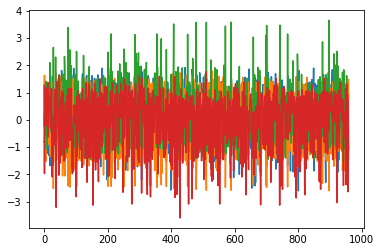

In [80]:
plt.plot(dp.X_train[0])

In [69]:
display_loss=True
display_loss and 10%2==0

True

In [118]:
class LogReg():

    def __init__(self, df, learning='GD', standardize=False, train_size=0.7, randomize=True):
        self.w = None
        self.b = None
        self.learning = learning
        self.df = df
        self.train_size = train_size
        self.randomize = randomize
        self.standardize = standardize
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_split()
        if standardize:
            self.standard()
    
    def train_test_split(self):
        data = np.array(self.df)
        train_size=self.train_size
        
        if self.randomize:
            np.random.shuffle(data)

        X = data[:,:-1]
        y = data[:,-1]

        train = int(train_size * X.shape[0])
        test = int((1-train_size) * X.shape[0])

        X_train_out = np.zeros((train, X.shape[1]))
        X_test_out = np.zeros((test, X.shape[1]))
        y_train_out = np.zeros(train)
        y_test_out = np.zeros(test)

        X_train = X[0 : train]
        X_test = X[train : train+test] 
        y_train = y[0 : train]
        y_test = y[train : train+test] 

        return X_train, X_test, y_train, y_test

    def standard(self):
        self.X_train = (self.X_train - self.X_train.mean(axis=0)) / self.X_train.std(axis=0)
        self.X_test = (self.X_test[j] - self.X_train.mean(axis=0)) / self.X_train.std(axis=0)  
  
    def perceptron(self, X):
        return np.dot(X, self.w.T) + self.b

    def sigmoid(self, X):
        return 1.0 / (1.0 + np.exp(-X))

    def grad_w(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred) * x
  
    def grad_b(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred)

    def mean_squared_error(self, y_pred, y):
        return sum([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])/len([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])
    
    def accuracy(self, y_pred, y):
        correct = 0
        for i in range(y.shape[0]):
            if y_pred[i]>0.5:
                yp=1
            else:
                yp=0
            if y[i] == yp:
                correct += 1
        return correct / float(y.shape[0])

    def fit(self, X, Y, epochs = 1, learning_rate = 1, batch_size=1, intialize = False, display_loss=False):
    
        #intialize
        if intialize:
            self.w = np.random.randn(1, X.shape[1])
            self.b = 0

        if display_loss:
            loss={}
            accuracy={}

        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            dw = 0
            db = 0

            if self.learning == 'GD':
                for x, y in zip(X, Y):
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                self.w -= learning_rate * dw
                self.b -= learning_rate * db


            if self.learning == 'SGD':
                for j in range(X.shape[0]):
                    randInt = np.random.randint(0,X.shape[0])
                    x = X[randInt, :]
                    y = Y[randInt]
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                self.w -= learning_rate * dw
                self.b -= learning_rate * db

            if display_loss:
                Y_pred = self.sigmoid(self.perceptron(X))
                loss[i] = self.mean_squared_error(Y_pred,Y)[0]
                accuracy[i] = self.accuracy(Y_pred,Y)
                if i%50==0:
                    print('Epoch:', i,'Loss:', loss[i],'Accuracy:', accuracy[i])

        if display_loss:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')

            plt.subplot(2, 1, 2)
            plt.plot(list(accuracy.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            
            plt.show()

    def predict(self, X):
        Y_pred = []
        for x in X:
            y_pred = self.sigmoid(self.perceptron(x))
            Y_pred.append(y_pred)
        return np.array(Y_pred)
    
    def binarize(self, X):
        y_pred = self.predict(X)
        Y_p = []
        for y in range(y_pred.shape[0]):
            if y_pred[y]>0.5:
                Y_p+=[1]
            else:
                Y_p+=[0]
        return np.array(Y_p)

    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''

        y_pred = self.binarize(x_test)
        dict = self.report(y_pred, y_test)
        print('Classification Report') 
        n = np.array(list(dict.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        self.confusion_matrix(dict)

    def cross_val(self, k, epochs=2000, learning_rate=0.015):
        '''
        Performs k-fold validation on the given data.
        
        Parameters:
            data
            k: No. of folds
        '''
        
        TP, TN, FP, FN, Total, accuracy, recall, precision=0, 0, 0, 0, 0, 0, 0, 0

        print('Total of 10 Splits:')        
        for i in range(k):
            
            print('Split', i+1,': ')
            X_train, X_test, Y_train, Y_test = self.train_test_split()  
            if self.standardize:
                self.standard()
                
            print('Training the Model...')
            self.fit(X_train, Y_train, epochs, learning_rate=learning_rate , intialize = True, display_loss=True)
            print('Trained the Model.')

            y_pred = self.binarize(X_test)            
            metric_dict = self.report(y_pred, Y_test)
            print('The most important feature is \'attr', np.argmax(self.w), '\'','with weight', self.w[0][np.argmax(self.w)])
            
            TP+=metric_dict['TP']
            TN+=metric_dict['TN']
            FP+=metric_dict['FP']
            FN+=metric_dict['FN']
            Total+=metric_dict['Total']
            accuracy+=metric_dict['Accuracy']
            precision+=metric_dict['Precision']
            recall+=metric_dict['Recall']
            
            self.evaluate(X_test, Y_test)
        
        avg = {'TP':TP/k, 'TN':TN/k, 'FP':FP/k, 'FN':FN/k, 'Total':Total/k, 'Accuracy':accuracy/k, 'Recall':recall/k, 'Precision':precision/k}
        
        print('Final Classification Report') 
        n = np.array(list(avg.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        self.confusion_matrix(avg)
    
    def report(self, y_pred, y_test):
        '''
        calculates precision and recall metrics
        Parameters:
            y_pred: predicted labels on a testing set
            y_test: true labels of the testing set
        '''
        
        TP=0
        TN=0
        FP=0
        FN=0
        Total=len(y_pred)
        for pred, test in zip(y_pred, y_test):
            if pred==test:
                if pred==0:
                    TN+=1
                else:
                    TP+=1
            else:
                if pred==1:
                    FP+=1
                else:
                    FN+=1
        
        accuracy = (TP+TN) / Total
        recall = TP / (TP+FN)
        precision = TP / (TP+FP)
        
        return {'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'Total':Total, 'Accuracy':accuracy, 'Recall':recall, 'Precision':precision}
        
    def confusion_matrix(self, report_val):
        '''
        Plots the confusion Matrix of the given data.
        '''
        
        fig, ax = plt.subplots()
        classes = ['Positive', 'Negitive']
        t = report_val['Total']
        report = np.array([[report_val['TN']/t, report_val['FP']/t], [report_val['FN']/t, report_val['TP']/t]])
        im = ax.imshow(report, cmap = 'Blues')

        ax.set_xticks(np.arange(len(classes)))
        ax.set_yticks(np.arange(len(classes)))

        ax.set_xticklabels(classes)
        ax.set_yticklabels(classes)


        plt.setp(ax.get_xticklabels(), rotation_mode="anchor")
        
        group_names = ['True Neg','False Pos', 'False Neg','True Pos']
        group_percentages = ['{0:.2%}'.format(value) for value in report.flatten()]

        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        for i in range(len(classes)):
            for j in range(len(classes)):
                text = ax.text(j, i, labels[i, j], ha="center", va="center")

        ax.set_title('Confusion Matrix', fontdict = {'size':18}, pad = 20)
        
        fig.tight_layout()
        plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
        plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
        plt.show()

## Trial - Model Testing

In [8]:
def to_numpy_array(df):
    return np.array(df.iloc[:,:-1]), np.array(df.iloc[:,-1])

In [9]:
def shuffle_in_unison(X, y):
    r = np.random.RandomState()
    state = r.get_state()
    np.random.shuffle(X)
    np.random.set_state(state)
    np.random.shuffle(y)
    return X, y

In [25]:
def train_test_split(df, train_size=0.7, randomize=True):

    data = np.array(df)
    
    if randomize:
        np.random.shuffle(data)

    X = data[:,:-1]
    y = data[:,-1]

    train = int(train_size * X.shape[0])
    test = int((1-train_size) * X.shape[0])

    X_train_out = np.zeros((train, X.shape[1]))
    X_test_out = np.zeros((test, X.shape[1]))
    y_train_out = np.zeros(train)
    y_test_out = np.zeros(test)

    X_train = X[0 : train]
    X_test = X[train : train+test] 
    y_train = y[0 : train]
    y_test = y[train : train+test] 

    return X_train, X_test, y_train, y_test

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df)

In [27]:
s2 = LogReg(learning='GD')

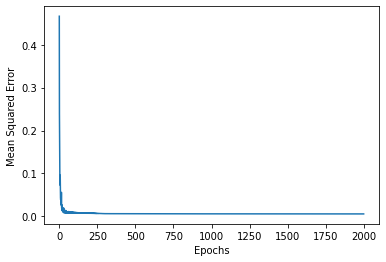

In [28]:
s2.fit(X_train, y_train, epochs=2000, learning_rate=0.015, intialize=True, display_loss=True)

In [146]:
s = LogReg(learning='GD')

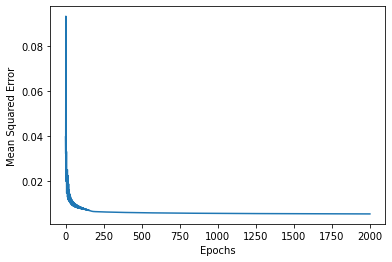

In [149]:
s.fit(X_train, y_train, epochs=2000, learning_rate=0.015, intialize=True, display_loss=True)

In [154]:
y_pred = predict(X_test)

In [153]:
def predict(X):
    Y_pred = []
    for x in X:
      y_pred = s.sigmoid(s.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

In [158]:
Y_p = []
for y in range(y_pred.shape[0]):
  if y_pred[y]>0.5:
    Y_p+=[1]
  else:
    Y_p+=[0]

In [156]:
y_pred.shape

(411, 1)

In [159]:
accuracy_score(y_test, np.array(Y_p))

0.9878345498783455

In [164]:
X_t, y_t = shuffle_in_unison(X, y, 0)

In [166]:
X_t.shape, y_t.shape

((1372, 4), (1372,))

In [195]:
X, X_t

(array([[ -1.7713  , -10.7665  ,  10.2184  ,  -1.0043  ],
        [  5.1321  ,  -0.031048,   0.32616 ,   1.1151  ],
        [ -2.0149  ,   3.6874  ,  -1.9385  ,  -3.8918  ],
        ...,
        [  0.6005  ,   0.99945 ,  -2.2126  ,   0.097399],
        [  2.0165  ,  -0.25246 ,   5.1707  ,   1.0763  ],
        [ -2.0759  ,  10.8223  ,   2.6439  ,  -4.837   ]]),
 array([[ -1.7713  , -10.7665  ,  10.2184  ,  -1.0043  ],
        [  5.1321  ,  -0.031048,   0.32616 ,   1.1151  ],
        [ -2.0149  ,   3.6874  ,  -1.9385  ,  -3.8918  ],
        ...,
        [  0.6005  ,   0.99945 ,  -2.2126  ,   0.097399],
        [  2.0165  ,  -0.25246 ,   5.1707  ,   1.0763  ],
        [ -2.0759  ,  10.8223  ,   2.6439  ,  -4.837   ]]))

In [167]:
train_size=0.7
train = int(train_size * X_t.shape[0])
test = int((1-train_size) * X_t.shape[0])

X_train_out = np.zeros((train, X_t.shape[1]))
X_test_out = np.zeros((test, X_t.shape[1]))
y_train_out = np.zeros(train)
y_test_out = np.zeros(test)

X_train = X[0 : train]
X_test = X[train : train+test] 
y_train = y[0 : train]
y_test = y[train : train+test] 

In [168]:
s1 = LogReg(learning='GD')

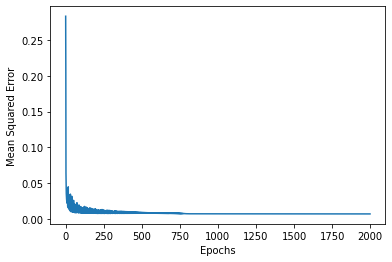

In [169]:
s1.fit(X_train, y_train, epochs=2000, learning_rate=0.015, intialize=True, display_loss=True)

In [170]:
y_pred = predict(X_test)

In [171]:
Y_p = []
for y in range(y_pred.shape[0]):
  if y_pred[y]>0.5:
    Y_p+=[1]
  else:
    Y_p+=[0]

In [172]:
accuracy_score(y_test, np.array(Y_p))

0.9927007299270073

In [ ]:
s1.evaluate(X_test, y_test)

In [179]:
d1 = DataPreprocess(df)

In [180]:
s2 = LogReg(learning='GD')

In [189]:
d1.X_train[0], X_train

(array([[ 4.2756  , -2.6528  ,  2.1375  ,  0.94437 ],
        [ 2.3925  ,  9.798   , -3.0361  , -2.8224  ],
        [ 1.9429  ,  6.3961  ,  0.092248,  0.58102 ],
        ...,
        [ 2.877   , -4.0599  ,  3.6259  , -0.32544 ],
        [ 2.6719  ,  3.0646  ,  0.37158 ,  0.58619 ],
        [ 1.7331  ,  3.9544  , -4.7412  , -2.5017  ]]),
 array([[ -1.7713  , -10.7665  ,  10.2184  ,  -1.0043  ],
        [  5.1321  ,  -0.031048,   0.32616 ,   1.1151  ],
        [ -2.0149  ,   3.6874  ,  -1.9385  ,  -3.8918  ],
        ...,
        [  3.8999  ,   1.734   ,   1.6011  ,   0.96765 ],
        [  0.3798  ,   0.7098  ,   0.7572  ,  -0.4444  ],
        [ -0.7056  ,   8.7241  ,   2.2215  ,  -4.5965  ]]))

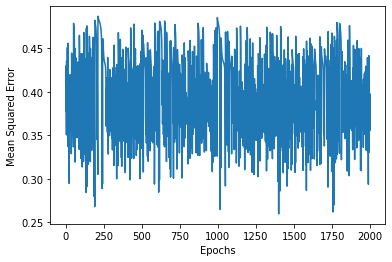

In [183]:
s2.fit(d1.X_train[0], d1.y_train[0], epochs=2000, learning_rate=0.015, intialize=True, display_loss=True)

## Gradient Descent

In [119]:
sn = LogReg(df)

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.14979708885923487 Accuracy: 0.821875
Epoch: 50 Loss: 0.010793596287493146 Accuracy: 0.9854166666666667
Epoch: 100 Loss: 0.011823561899831731 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.009584580492064987 Accuracy: 0.9875
Epoch: 200 Loss: 0.009097268167660481 Accuracy: 0.9875
Epoch: 250 Loss: 0.007739893974698076 Accuracy: 0.990625



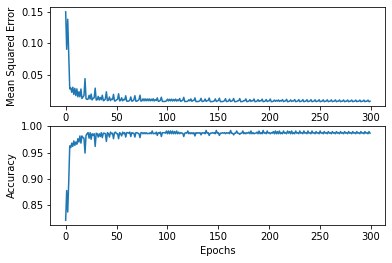

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.1824945029822651
Classification Report
                             
TP                        179
TN                        229
FP                          1
FN                          2
Total                     411
Accuracy   0.9927007299270073
Recall      0.988950276243094
Precision  0.9944444444444445


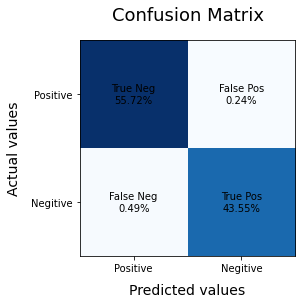

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.2280090135084348 Accuracy: 0.7229166666666667
Epoch: 50 Loss: 0.012216284644717171 Accuracy: 0.984375
Epoch: 100 Loss: 0.007537987889918494 Accuracy: 0.990625
Epoch: 150 Loss: 0.008460971780223616 Accuracy: 0.990625
Epoch: 200 Loss: 0.007439276639455037 Accuracy: 0.990625
Epoch: 250 Loss: 0.007273033568729973 Accuracy: 0.990625



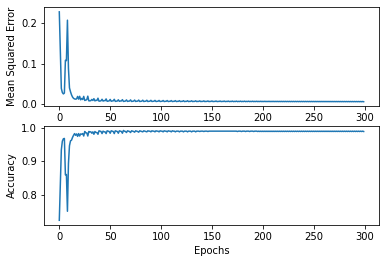

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.32422180404182055
Classification Report
                             
TP                        175
TN                        231
FP                          4
FN                          1
Total                     411
Accuracy   0.9878345498783455
Recall     0.9943181818181818
Precision  0.9776536312849162


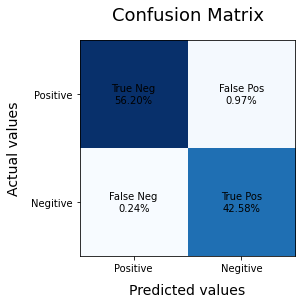

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.16928973233698072 Accuracy: 0.7583333333333333
Epoch: 50 Loss: 0.011979925882762359 Accuracy: 0.9833333333333333
Epoch: 100 Loss: 0.0078084335683543905 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.007954970031190688 Accuracy: 0.9895833333333334
Epoch: 200 Loss: 0.0074638850994469845 Accuracy: 0.9895833333333334
Epoch: 250 Loss: 0.007166089362142204 Accuracy: 0.9895833333333334



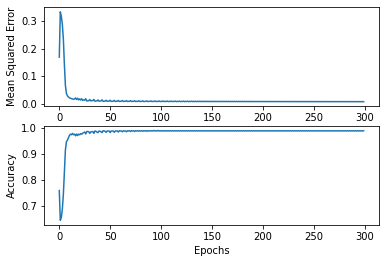

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.33646597666465855
Classification Report
                             
TP                        176
TN                        231
FP                          4
FN                          0
Total                     411
Accuracy   0.9902676399026764
Recall                    1.0
Precision  0.9777777777777777


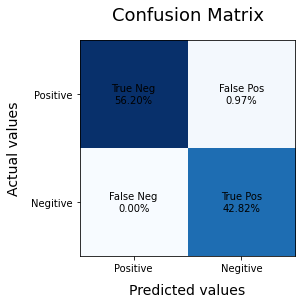

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.1403212968034932 Accuracy: 0.821875
Epoch: 50 Loss: 0.009671804660683351 Accuracy: 0.9895833333333334
Epoch: 100 Loss: 0.01285269878387399 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.0071916260127368814 Accuracy: 0.9927083333333333
Epoch: 200 Loss: 0.007427762899516247 Accuracy: 0.990625
Epoch: 250 Loss: 0.006981049006147078 Accuracy: 0.9916666666666667



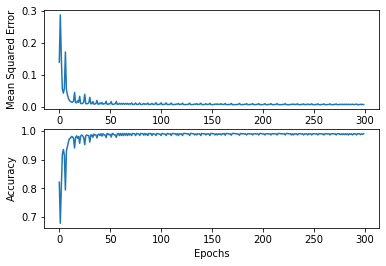

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.3388170438000466
Classification Report
                             
TP                        178
TN                        228
FP                          4
FN                          1
Total                     411
Accuracy   0.9878345498783455
Recall      0.994413407821229
Precision   0.978021978021978


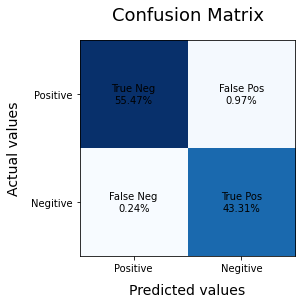

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.050764119488490085 Accuracy: 0.928125
Epoch: 50 Loss: 0.008575324746122152 Accuracy: 0.9916666666666667
Epoch: 100 Loss: 0.006643555077412123 Accuracy: 0.99375
Epoch: 150 Loss: 0.00604585044591185 Accuracy: 0.99375
Epoch: 200 Loss: 0.005727628833521155 Accuracy: 0.99375
Epoch: 250 Loss: 0.005527207358088443 Accuracy: 0.99375



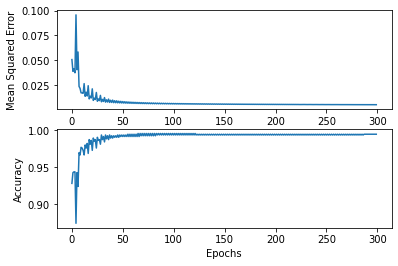

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.39726829488789034
Classification Report
                             
TP                        168
TN                        237
FP                          6
FN                          0
Total                     411
Accuracy   0.9854014598540146
Recall                    1.0
Precision  0.9655172413793104


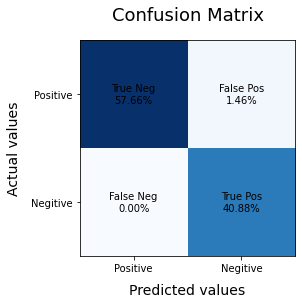

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.3470556024818297 Accuracy: 0.6291666666666667
Epoch: 50 Loss: 0.0073502317207365855 Accuracy: 0.9927083333333333
Epoch: 100 Loss: 0.006649214002574221 Accuracy: 0.99375
Epoch: 150 Loss: 0.006821979704223891 Accuracy: 0.9916666666666667
Epoch: 200 Loss: 0.0064026610474042355 Accuracy: 0.9927083333333333
Epoch: 250 Loss: 0.006327620013888559 Accuracy: 0.9927083333333333



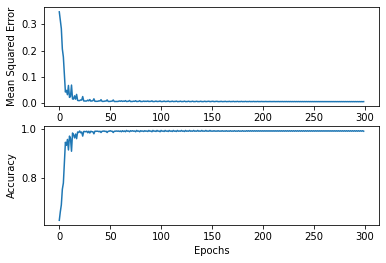

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.3659813612425676
Classification Report
                             
TP                        182
TN                        223
FP                          5
FN                          1
Total                     411
Accuracy   0.9854014598540146
Recall      0.994535519125683
Precision  0.9732620320855615


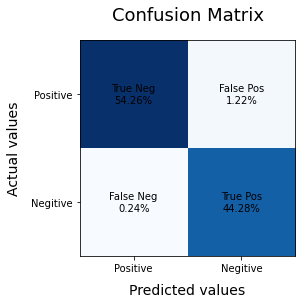

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.6255504493310713 Accuracy: 0.3072916666666667
Epoch: 50 Loss: 0.008453053065635464 Accuracy: 0.9875
Epoch: 100 Loss: 0.00932672408558354 Accuracy: 0.990625
Epoch: 150 Loss: 0.007641571948679981 Accuracy: 0.9895833333333334
Epoch: 200 Loss: 0.008881778031899025 Accuracy: 0.9864583333333333
Epoch: 250 Loss: 0.0099948610152949 Accuracy: 0.9854166666666667



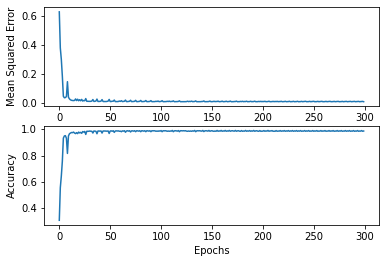

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.12959913842822957
Classification Report
                             
TP                        172
TN                        236
FP                          2
FN                          1
Total                     411
Accuracy   0.9927007299270073
Recall     0.9942196531791907
Precision  0.9885057471264368


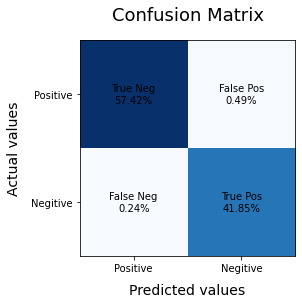

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.4147068934728028 Accuracy: 0.5416666666666666
Epoch: 50 Loss: 0.010395371764515856 Accuracy: 0.9875
Epoch: 100 Loss: 0.007148983836979275 Accuracy: 0.990625
Epoch: 150 Loss: 0.006964726519006242 Accuracy: 0.990625
Epoch: 200 Loss: 0.0063943515075854255 Accuracy: 0.990625
Epoch: 250 Loss: 0.0059669767170658075 Accuracy: 0.990625



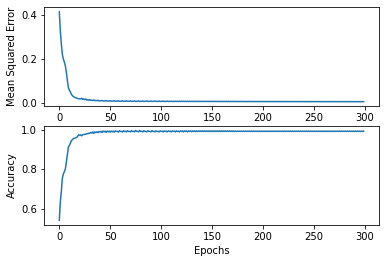

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.19613716233590656
Classification Report
                             
TP                        178
TN                        222
FP                          2
FN                          9
Total                     411
Accuracy   0.9732360097323601
Recall     0.9518716577540107
Precision  0.9888888888888889


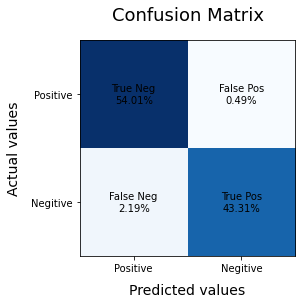

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.14770289859324276 Accuracy: 0.7885416666666667
Epoch: 50 Loss: 0.007441292153432404 Accuracy: 0.990625
Epoch: 100 Loss: 0.010734666346722434 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.008210633023254282 Accuracy: 0.9885416666666667
Epoch: 200 Loss: 0.00613000207378628 Accuracy: 0.9895833333333334
Epoch: 250 Loss: 0.008250549918480463 Accuracy: 0.9885416666666667



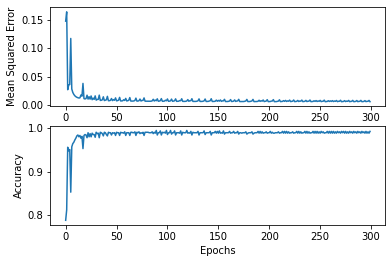

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.19525978734913638
Classification Report
                             
TP                        171
TN                        236
FP                          1
FN                          3
Total                     411
Accuracy   0.9902676399026764
Recall     0.9827586206896551
Precision  0.9941860465116279


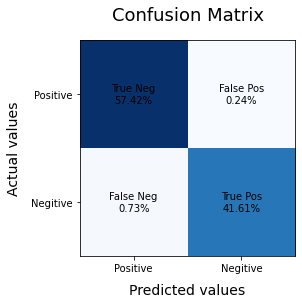

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.22899864672404385 Accuracy: 0.6833333333333333
Epoch: 50 Loss: 0.010893033682004442 Accuracy: 0.984375
Epoch: 100 Loss: 0.00845620427423879 Accuracy: 0.990625
Epoch: 150 Loss: 0.00937497340058659 Accuracy: 0.9864583333333333
Epoch: 200 Loss: 0.012339957382184689 Accuracy: 0.984375
Epoch: 250 Loss: 0.010684594047405472 Accuracy: 0.9864583333333333



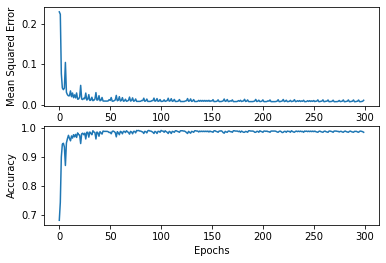

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.31903103797899024
Classification Report
                             
TP                        182
TN                        226
FP                          2
FN                          1
Total                     411
Accuracy   0.9927007299270073
Recall      0.994535519125683
Precision  0.9891304347826086


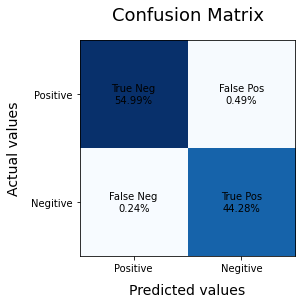

Final Classification Report
                             
TP                      176.1
TN                      229.9
FP                        3.1
FN                        1.9
Total                   411.0
Accuracy   0.9878345498783455
Recall     0.9895602835756728
Precision  0.9827388222303552


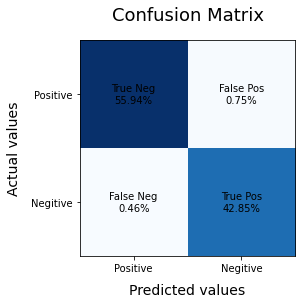

In [120]:
sn.cross_val(10, epochs=300, learning_rate=0.015)

## Stochastic Gradient Descent

In [121]:
SGD = LogReg(df, learning='SGD')

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.2823450523497489 Accuracy: 0.696875
Epoch: 50 Loss: 0.010637690140664706 Accuracy: 0.9864583333333333
Epoch: 100 Loss: 0.014266884028927507 Accuracy: 0.9791666666666666
Epoch: 150 Loss: 0.006734971702622963 Accuracy: 0.9916666666666667
Epoch: 200 Loss: 0.013253989032632519 Accuracy: 0.984375
Epoch: 250 Loss: 0.006445083517443668 Accuracy: 0.9895833333333334



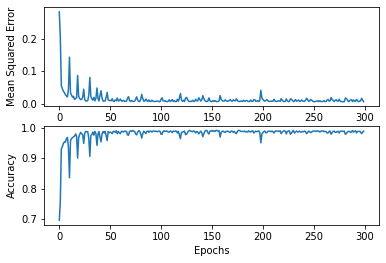

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.5606612013758543
Classification Report
                             
TP                        184
TN                        222
FP                          3
FN                          2
Total                     411
Accuracy   0.9878345498783455
Recall      0.989247311827957
Precision   0.983957219251337


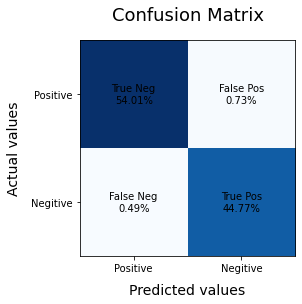

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.3257494313410974 Accuracy: 0.6520833333333333
Epoch: 50 Loss: 0.014344524435147173 Accuracy: 0.98125
Epoch: 100 Loss: 0.009589312812076345 Accuracy: 0.9885416666666667
Epoch: 150 Loss: 0.008779840773684587 Accuracy: 0.9885416666666667
Epoch: 200 Loss: 0.00921176620788813 Accuracy: 0.9885416666666667
Epoch: 250 Loss: 0.010691732624313648 Accuracy: 0.9854166666666667



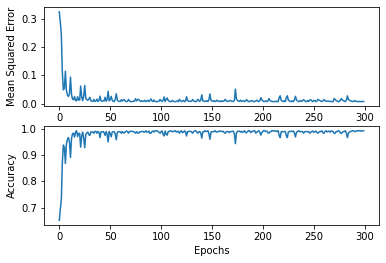

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.7370581864590212
Classification Report
                             
TP                        177
TN                        230
FP                          3
FN                          1
Total                     411
Accuracy   0.9902676399026764
Recall     0.9943820224719101
Precision  0.9833333333333333


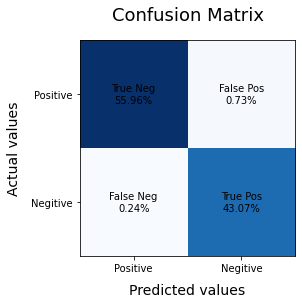

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.3047194172619766 Accuracy: 0.678125
Epoch: 50 Loss: 0.01081504890433253 Accuracy: 0.9864583333333333
Epoch: 100 Loss: 0.0053817802215886225 Accuracy: 0.9958333333333333
Epoch: 150 Loss: 0.0063047839663821085 Accuracy: 0.9947916666666666
Epoch: 200 Loss: 0.005204068156399676 Accuracy: 0.9958333333333333
Epoch: 250 Loss: 0.005365465119461361 Accuracy: 0.9958333333333333



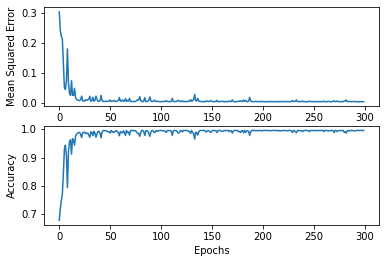

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.9123238958691652
Classification Report
                             
TP                        170
TN                        235
FP                          6
FN                          0
Total                     411
Accuracy   0.9854014598540146
Recall                    1.0
Precision  0.9659090909090909


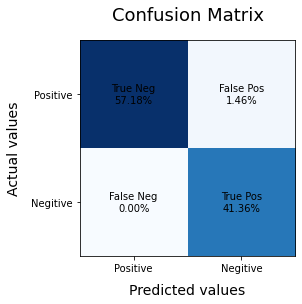

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.2683796571396936 Accuracy: 0.684375
Epoch: 50 Loss: 0.006130565391169567 Accuracy: 0.9927083333333333
Epoch: 100 Loss: 0.010201355573269925 Accuracy: 0.9885416666666667
Epoch: 150 Loss: 0.007064820491648172 Accuracy: 0.990625
Epoch: 200 Loss: 0.006901226489881225 Accuracy: 0.990625
Epoch: 250 Loss: 0.013355436068683103 Accuracy: 0.98125



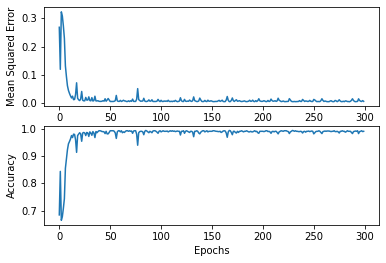

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.4644182331193705
Classification Report
                             
TP                        177
TN                        227
FP                          4
FN                          3
Total                     411
Accuracy   0.9829683698296837
Recall     0.9833333333333333
Precision  0.9779005524861878


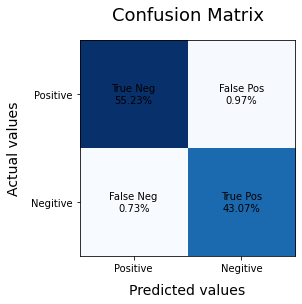

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.1834753144985736 Accuracy: 0.7947916666666667
Epoch: 50 Loss: 0.012861831221259761 Accuracy: 0.984375
Epoch: 100 Loss: 0.007197917036058722 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.012467928121468063 Accuracy: 0.9854166666666667
Epoch: 200 Loss: 0.013795224057290167 Accuracy: 0.98125
Epoch: 250 Loss: 0.005930107602259817 Accuracy: 0.9895833333333334



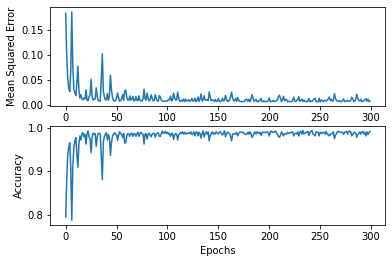

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.2527342504231424
Classification Report
                             
TP                        194
TN                        206
FP                          2
FN                          9
Total                     411
Accuracy   0.9732360097323601
Recall     0.9556650246305419
Precision  0.9897959183673469


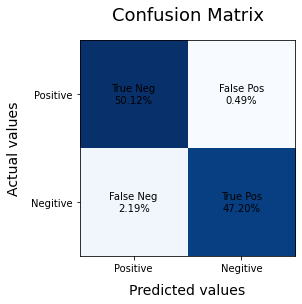

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.36653819433666723 Accuracy: 0.625
Epoch: 50 Loss: 0.013565416237925737 Accuracy: 0.9822916666666667
Epoch: 100 Loss: 0.006549417044823338 Accuracy: 0.9927083333333333
Epoch: 150 Loss: 0.012097082699156879 Accuracy: 0.9864583333333333
Epoch: 200 Loss: 0.006861232314046484 Accuracy: 0.990625
Epoch: 250 Loss: 0.016965029126405025 Accuracy: 0.98125



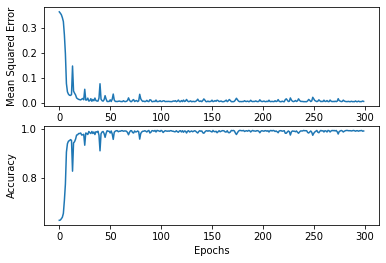

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.6130738867976359
Classification Report
                             
TP                        180
TN                        225
FP                          4
FN                          2
Total                     411
Accuracy   0.9854014598540146
Recall      0.989010989010989
Precision  0.9782608695652174


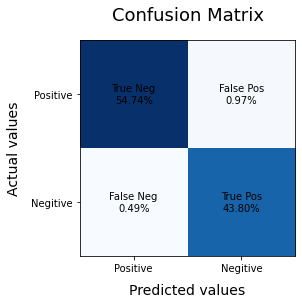

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.3445923076443476 Accuracy: 0.6447916666666667
Epoch: 50 Loss: 0.013453328110912677 Accuracy: 0.978125
Epoch: 100 Loss: 0.008386618270238665 Accuracy: 0.984375
Epoch: 150 Loss: 0.009349172209107541 Accuracy: 0.9864583333333333
Epoch: 200 Loss: 0.015191414195923387 Accuracy: 0.9833333333333333
Epoch: 250 Loss: 0.010253009562612053 Accuracy: 0.9833333333333333



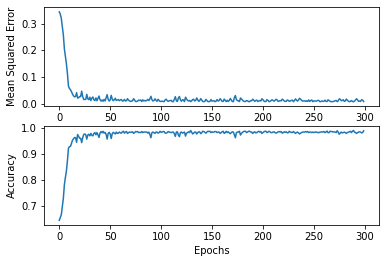

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.27772240630437045
Classification Report
                             
TP                        183
TN                        225
FP                          1
FN                          2
Total                     411
Accuracy   0.9927007299270073
Recall     0.9891891891891892
Precision  0.9945652173913043


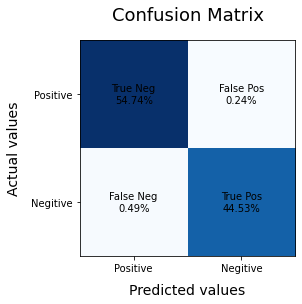

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.2988359895062032 Accuracy: 0.6885416666666667
Epoch: 50 Loss: 0.016280681973310174 Accuracy: 0.9791666666666666
Epoch: 100 Loss: 0.015420889445811261 Accuracy: 0.98125
Epoch: 150 Loss: 0.011717135246412998 Accuracy: 0.9864583333333333
Epoch: 200 Loss: 0.007890449001379392 Accuracy: 0.9895833333333334
Epoch: 250 Loss: 0.014570238896841248 Accuracy: 0.98125



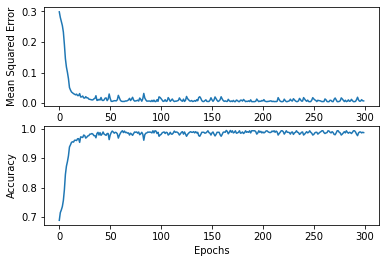

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.5286282534651549
Classification Report
                             
TP                        200
TN                        205
FP                          2
FN                          4
Total                     411
Accuracy   0.9854014598540146
Recall     0.9803921568627451
Precision  0.9900990099009901


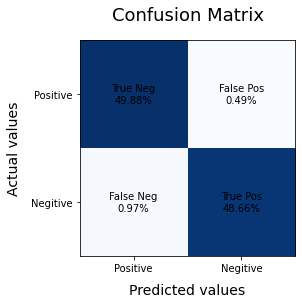

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.1308283651522367 Accuracy: 0.825
Epoch: 50 Loss: 0.011353463331025786 Accuracy: 0.9854166666666667
Epoch: 100 Loss: 0.006387804749412042 Accuracy: 0.990625
Epoch: 150 Loss: 0.007014808627115692 Accuracy: 0.990625
Epoch: 200 Loss: 0.008932550454581939 Accuracy: 0.9895833333333334
Epoch: 250 Loss: 0.006146427457118951 Accuracy: 0.99375



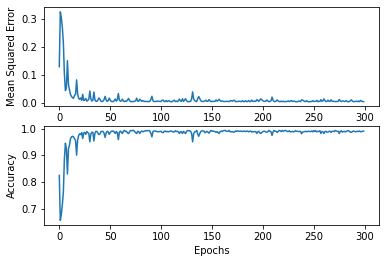

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.5359629265898525
Classification Report
                             
TP                        196
TN                        210
FP                          4
FN                          1
Total                     411
Accuracy   0.9878345498783455
Recall     0.9949238578680203
Precision                0.98


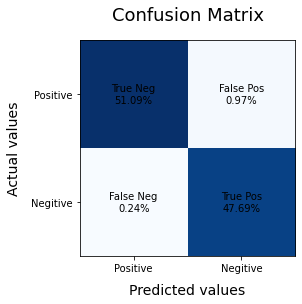

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.2597097066944307 Accuracy: 0.7291666666666666
Epoch: 50 Loss: 0.009360623838140677 Accuracy: 0.9822916666666667
Epoch: 100 Loss: 0.00880690971171374 Accuracy: 0.9875
Epoch: 150 Loss: 0.01310584328210999 Accuracy: 0.9833333333333333
Epoch: 200 Loss: 0.008519816181366211 Accuracy: 0.984375
Epoch: 250 Loss: 0.009337712554963825 Accuracy: 0.984375



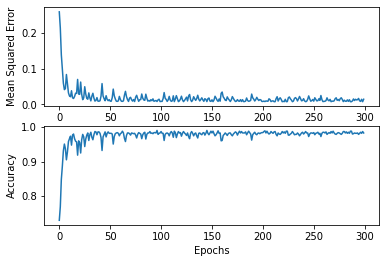

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.3098313105768754
Classification Report
                             
TP                        170
TN                        235
FP                          1
FN                          5
Total                     411
Accuracy   0.9854014598540146
Recall     0.9714285714285714
Precision  0.9941520467836257


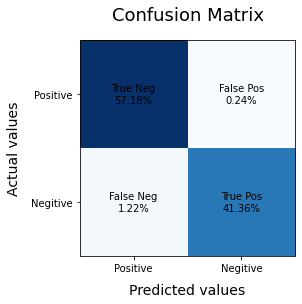

Final Classification Report
                             
TP                      183.1
TN                      222.0
FP                        3.0
FN                        2.9
Total                   411.0
Accuracy   0.9856447688564476
Recall     0.9847572456623258
Precision  0.9837973257988434


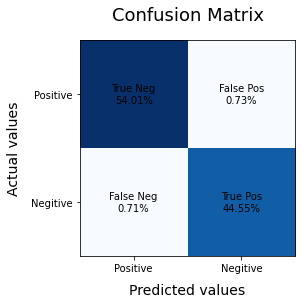

In [123]:
SGD.cross_val(10, epochs=300, learning_rate=0.03)